In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import s3fs
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
import s3fs
blim=pd.read_csv('s3://uploadtp/BI/INSIGHTS/Matriz_addons_activos_20210924.csv',usecols=['cuenta','blim'],dtype={'cuenta':'str'})
product=pd.read_csv('s3://uploadtp/BI/Modelos_logs/INPUT/ago_21/product_holding_model_feed_ago21.csv000',
                           dtype={'account':'str'}, low_memory=False)

data=product.merge(blim, left_on='account', right_on='cuenta')
data.drop(columns=['cuenta'], inplace=True)
data

,account,edad,gpo_edad,plan_homologado,renta,familia,tipo_de_pago,cluster,plaza,distrito,...,ph_added_tele_flg,ph_plan_tv_incluidas,ph_netflix,ph_amazon,ph_fox_comb_flg,ph_hbo_comb_flg,ph_updl_100_or_greater_mbps,ph_wifi_addons,ph_add_channels,blim
0,1.3248369,NaN,NaN,EMOCIONATE MAS 3P,1194.0,TOTALPLAY INTERNET MAS TELEVISION,TARJETA DE CREDITO,ANZURES 1,CENTRO - PONIENTE,POLANCO,...,0,1.0,0,0,0,0,1,NaN,NaN,0
1,1.3298979,NaN,NaN,TOTAL 3P,1346.0,TOTALPLAY INTERNET MAS TELEVISION,TARJETA DE CREDITO,SANTA URSULA 1,CENTRO - PONIENTE,PEDREGAL,...,0,2.0,0,0,0,0,1,1.0,0.0,0
2,1.3306319,69.18,NaN,SERIE 3,712.0,TOTALPLAY INTERNET MAS TELEVISION,EFECTIVO,DEL VALLE / NAPOLES,CENTRO - PONIENTE,CONDESA,...,0,1.0,0,0,0,0,1,NaN,NaN,0
3,1.3325356,57.32,NaN,DIVIERTETE MAS 3P,694.0,TOTALPLAY INTERNET MAS TELEVISION,TARJETA DE CREDITO,CONDESA,CENTRO - PONIENTE,CONDESA,...,0,1.0,0,0,0,0,1,0.0,1.0,0
4,1.3307403,61.67,NaN,SIN LIMITE 3P,1877.0,TOTALPLAY INTERNET MAS TELEVISION,TARJETA DE CREDITO,COYOACAN / SAN ANGEL,CENTRO - PONIENTE,PEDREGAL,...,0,3.0,0,0,0,0,1,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2642610,0106529834,31.15,NaN,INICIAL 3P,574.0,TOTALPLAY INTERNET MAS TELEVISION,EFECTIVO,AMPLIACION HACIENDA REAL,MEXICALI,MEXICALI,...,0,1.0,0,0,0,0,1,NaN,NaN,0
2642611,0106530354,39.87,NaN,DIVIERTETE MAS 3P,703.0,TOTALPLAY INTERNET MAS TELEVISION,TARJETA DE CREDITO,COAPA,CENTRO - PONIENTE,XOCHIMILCO,...,0,1.0,0,0,0,0,1,NaN,NaN,0
2642612,0106530479,47.10,NaN,INICIAL 3P,574.0,TOTALPLAY INTERNET MAS TELEVISION,EFECTIVO,AMPLIACION CENTENARIO 2A,HERMOSILLO,HERMOSILLO,...,0,1.0,0,0,0,0,1,NaN,NaN,0
2642613,0106530667,57.93,NaN,INICIAL 3P,574.0,TOTALPLAY INTERNET MAS TELEVISION,EFECTIVO,TEJALPA,CUERNAVACA,CUERNAVACA DE CORTEZ,...,0,1.0,0,0,0,0,1,NaN,NaN,0


In [ ]:
data.to_csv('Blim_data_cruda.csv')

In [3]:
megas=pd.read_csv(r's3://uploadtp/BI/modelos/rf_megas/input/ph_megas.csv',names=['account','plan_megas','AAA_megas'],
                  dtype={'account':'str'})
data=data.merge(megas,left_on='account',right_on='account',how='left')

In [4]:
moda=['renta','rent','avg_cluster_edad','edad_impute','plan_residencial_negocios',
      'plan_precio_lista','plan_precio_pronto_pago','as_next_fam_plan_play_num']
fill_0=['rent_addons','plan_tv_incluidas','plan_num_diff','usg_siete_canales','usg_abierta','usg_paga','usg_premimum',
        'upsl_nbr_4_overage_margin','up_tot_3p_to_2p','up_tot_2p_to_3p','up_tot_2p_to_2p','up_tot_3p_to_3p','total_promo',
        'new_cons_videogames','new_cons_video','new_cons_ottstreaming','new_cons_musicstreaming','new_cons_socialmedia',
        'new_cons_cloud','new_cons_videoconference','new_cons_netflix','new_cons_primevideo','new_cons_disneyplus',
        'tel_duracion_semana','tel_duracion_fin_semana','tel_morning','tel_afternoon','tel_evening','tel_nigth','tel_overnigth',
        'tel_llamadas_saliente','tel_llamadas_internacional','tel_duracion_internacional_hr','carr_telmex_duracion',
        'carr_izzi_duracion','carr_sky_duracion','carr_dish_duracion','carr_telmex_llamadas','carr_izzi_llamadas','carr_sky_llamadas',
        'carr_dish_llamadas','carr_tot_duracion','carr_tot_llamadas','tot_cons','usg_tv_total','monto_pct_of_rent',
        'ph_plan_tv_incluidas','ph_wifi_addons']
prom=['score','usg_phone_nac_t','usg_n_stb','usg_phone_total_t','usg_tv_anytime','pop_age_18to24_pct','pct_hh_cell_phone',
     'pct_hh_internet','pct_hh_washing_machine','pct_hh_tv_subscription','pct_hh_tv','avg_occupants_per_dwelling',
     'pct_dwelling_1_room','pct_dwelling_2_room','pct_dwelling_3plus_room','new_cons_youtube','stb1','weekday',
      'weekend','morning','noon','evening','night','overnight','noticias','entretenimiento','comedia','telenovela','deportes',
      'otros','ph_add_channels']

dropr=['longitud','latitud','approved_plan','family_plan','as_next_fam_plan_cat','usg_phone_int_t',
      'dwnsl_nbr_4_overage_margin','up_sum_margen_crecimiento','up_sum_margen_paquete','up_max_up_megas_change',
     'up_max_down_megas_change','up_max_tv_change','up_max_minutos_nat_change','up_max_minutos_inter_change',
      'up_max_services_inc_change','up_max_precio_pronto_change','up_max_precio_lista_change','new_cons_hbo',
       'fecha_activacion_raw','fecha_activacion','ano_semana','cancel_year','cancel_month','cancelation_week',
       'cancelation_date','nse','edad','plan_internet_incluidas','plan_minutos_nacional'
       ,'plan_minutos_internacional','gpo_edad']

In [5]:
data['plan_megas_de_bajada'].fillna(data['plan_megas'],inplace=True)
data['plan_megas_de_subida'].fillna(data['plan_megas']/10,inplace=True)
data.dropna(subset = ["segmento_de_atraso"], inplace=True)
data.drop(columns='motive',inplace=True)

In [6]:
data['cancel_type'].fillna('SIN CANCELAR',inplace=True)
data['motivo'].fillna('SIN CANCELAR',inplace=True)
data['submotive'].fillna('SIN CANCELAR',inplace=True)
data['motive_detail'].fillna('SIN CANCELAR',inplace=True)
data['submotive_detail'].fillna('SIN CANCELAR',inplace=True)
data['churn_type'].fillna('SIN CHURN',inplace=True)
data['cancel_year'].fillna('0',inplace=True)
data['cancel_month'].fillna('0',inplace=True)
data['cancelation_week'].fillna('0',inplace=True)
data['cancelation_date'].fillna('0',inplace=True)
data['plan_servicios_incluidos'].fillna('NINGUNO',inplace=True)

In [7]:
data['as_nxt_app_pln'].fillna(data['plan_homologado'],inplace=True)
data['as_prev_fam_pln'].fillna(data['familia'],inplace=True)
data['as_next_total_rent'].fillna(data['as_next_total_rent'].mode()[0],inplace=True)
data['as_next_rent'].fillna(data['as_next_rent'].mode()[0],inplace=True)
data['as_nxt_des_svc'].fillna(data['as_nxt_des_svc'].mode()[0],inplace=True)
data['as_previous_total_rent'].fillna(data['total_rent'],inplace=True)
data['as_previous_rent'].fillna(data['rent'],inplace=True)
data['as_prev_app_pln'].fillna(data['plan_homologado'],inplace=True)
data['as_prev_des_svc'].fillna(data['desc_service'],inplace=True)
data['as_nxt_fam_pln'].fillna(data['familia'],inplace=True)
data['as_nxt_fam_pln'].fillna(data['familia'],inplace=True)
data['as_nxt_fam_pln'].fillna(data['familia'],inplace=True)

In [8]:
dr=['period','billing_month','as_prev_mth','as_nxt_mth']
data.drop(columns=dr,inplace=True)

In [9]:
for col in moda:
    data[col].fillna(data[col].mode()[0],inplace=True)
    
for col in fill_0:
    data[col].fillna(0,inplace=True)
    
for col in prom:
    data[col].fillna(data[col].mean(),inplace=True)

for col in dropr:
    data.drop(columns=col,inplace=True)

for col in data.columns.to_list():
    if data[col].isnull().sum()==2672192:
        data.drop(columns=col, inplace=True)

In [10]:
data['as_previous_rent'].fillna(data['as_previous_rent'].mode()[0],inplace=True)
data['plan_megas_de_subida'].fillna(data['plan_megas_de_subida'].mode()[0],inplace=True)
data['plan_megas_de_bajada'].fillna(data['plan_megas_de_bajada'].mode()[0],inplace=True)
data['usg_down_bytes_total'].fillna(data['usg_down_bytes_total'].mean(),inplace=True)
data['usg_up_bytes_total'].fillna(data['usg_up_bytes_total'].mean(),inplace=True)
data['as_previous_rent'].fillna(data['as_previous_rent'].mode()[0],inplace=True)
data['plan_megas_de_subida'].fillna(data['plan_megas_de_subida'].mode()[0],inplace=True)
data['plan_megas_de_bajada'].fillna(data['plan_megas_de_bajada'].mode()[0],inplace=True)
data['usg_down_bytes_total'].fillna(data['usg_down_bytes_total'].mean(),inplace=True)
data['usg_up_bytes_total'].fillna(data['usg_up_bytes_total'].mean(),inplace=True)
data['upsl_nbr_3_paquete_margin'].fillna(data['upsl_nbr_3_paquete_margin'].mean(),inplace=True)
data['dwnsl_nbr_3_paquete_margin'].fillna(data['dwnsl_nbr_3_paquete_margin'].mean(), inplace=True)
data.drop(columns=['tipo_persona','television','anytime','netflix','youtube','amazon','deezer','vod'], inplace=True)

In [11]:
for col in data.columns.to_list():
    print(f'NULL {col} : ',data[col].isnull().sum())

NULL account :  0
NULL plan_homologado :  0
NULL renta :  0
NULL familia :  0
NULL tipo_de_pago :  0
NULL cluster :  0
NULL plaza :  0
NULL distrito :  0
NULL canal_de_venta :  0
NULL mes_act :  0
NULL ano_act :  0
NULL meses_pagando :  0
NULL segmento_junio_2018 :  0
NULL motivo :  0
NULL geo_source :  0
NULL atraso :  0
NULL segmento_de_atraso :  0
NULL estatus :  0
NULL tipo_de_cobertura :  0
NULL donado :  0
NULL portado :  0
NULL ciclo :  0
NULL saldo :  0
NULL suspension :  0
NULL score :  0
NULL upselling_2019 :  0
NULL upselling_2020 :  0
NULL cancel_type :  0
NULL submotive :  0
NULL motive_detail :  0
NULL submotive_detail :  0
NULL churn_type :  0
NULL status :  0
NULL desc_service :  0
NULL rent_addons :  0
NULL rent :  0
NULL total_rent :  0
NULL as_previous_total_rent :  0
NULL as_next_total_rent :  0
NULL as_previous_rent :  0
NULL as_next_rent :  0
NULL as_prev_app_pln :  0
NULL as_nxt_app_pln :  0
NULL as_prev_fam_pln :  0
NULL as_nxt_fam_pln :  0
NULL as_prev_des_svc 

In [12]:
data.drop(columns=['addon_promo_category','mths_after_promo','plan_megas','AAA_megas'],inplace=True)

In [2]:
data.to_csv('Blim_Data.csv')


NameError: name 'data' is not defined

In [2]:
data=pd.read_csv('Blim_Data.csv',dtype={'account':'str'})
acc=data['account']


In [4]:
data.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
data_m=data.drop(columns='account')
matriz=data_m.corr(method='pearson')
matriz['columnas']=matriz.columns.tolist()
matriz

In [ ]:
matriz.drop(matriz[matriz['columnas'] == 'blim'].index, inplace = True)
matriz.plot.bar(x='columnas', y='blim',figsize=(30,10))

plt.title('Correlation')
plt.savefig('correlations_blim.png')

In [11]:
columnas.append('blim')
data=data[columnas]


# Random Forest

In [12]:
num_col = data.columns[(data.dtypes !='object').values].tolist()
cat_cols=data.columns[(data.dtypes == 'object').values].tolist()

for col in cat_cols:
        globals()['LE_{}'.format(col)] = LabelEncoder()
        data[col] = globals()['LE_{}'.format(col)].fit_transform(data[col])

In [13]:
Y=data['blim']
X=data.drop(columns=['blim'])

X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify=Y, train_size=0.8)

In [14]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [15]:

RFC=RandomForestClassifier(n_estimators = 400, class_weight='balanced',max_features='log2',  max_leaf_nodes=5000)
RFC.fit(X_train,y_train)

y_pred_train=RFC.predict(X_train)
y_pred_test=RFC.predict(X_test)


In [29]:
lista=list(y_pred_train)
lista.index(1)

31

In [16]:
print("Training Accuracy: ", 100 *  metrics.accuracy_score(y_train, y_pred_train,
                                        ))
print("Training Precision: ",100 * metrics.precision_score(y_train, y_pred_train))
print("Training Recall: ", 100 * metrics.recall_score(y_train, y_pred_train
                                                              ))
print("Training F1: ", 100 * metrics.f1_score(y_train, y_pred_train
                                                     ),'\n')


print('Test Accuracy: ', 100 * metrics.accuracy_score(y_test, y_pred_test
                                                             ))
print("Test Precision: ", 100 * metrics.precision_score(y_test, y_pred_test
                                                              ))
print("Test Recall: ", 100 * metrics.recall_score(y_test, y_pred_test,
                                                         ))
print("Test F1: ", 100 * metrics.f1_score(y_test, y_pred_test
                                                ),'\n')


print('Confussion Matrix Train :')
print(confusion_matrix(y_train,y_pred_train),'\n')

print('Confussion Matrix Test :')
print(confusion_matrix(y_test,y_pred_test))

Training Accuracy:  97.19901473109418
Training Precision:  22.850339536114294
Training Recall:  99.38082191780822
Training F1:  37.15722729274863 

Test Accuracy:  96.64296789251361
Test Precision:  11.340494573122973
Test Recall:  44.43226654975888
Test F1:  18.069174540916382 

Confussion Matrix Train :
[[2110779   61236]
 [    113   18137]] 

Confussion Matrix Test :
[[527158  15847]
 [  2535   2027]]


In [5]:
import pickle
#save
#with open('blim_1.pkl','wb') as f:
    #pickle.dump(RFC,f)

# load
with open('blim_1.pkl', 'rb') as f:
    model = pickle.load(f)

In [16]:
features=data.columns.to_list()
features.remove('account')
features.remove('blim')
feature_imp = pd.Series(RFC.feature_importances_,index=features).sort_values(ascending=False)


No handles with labels found to put in legend.


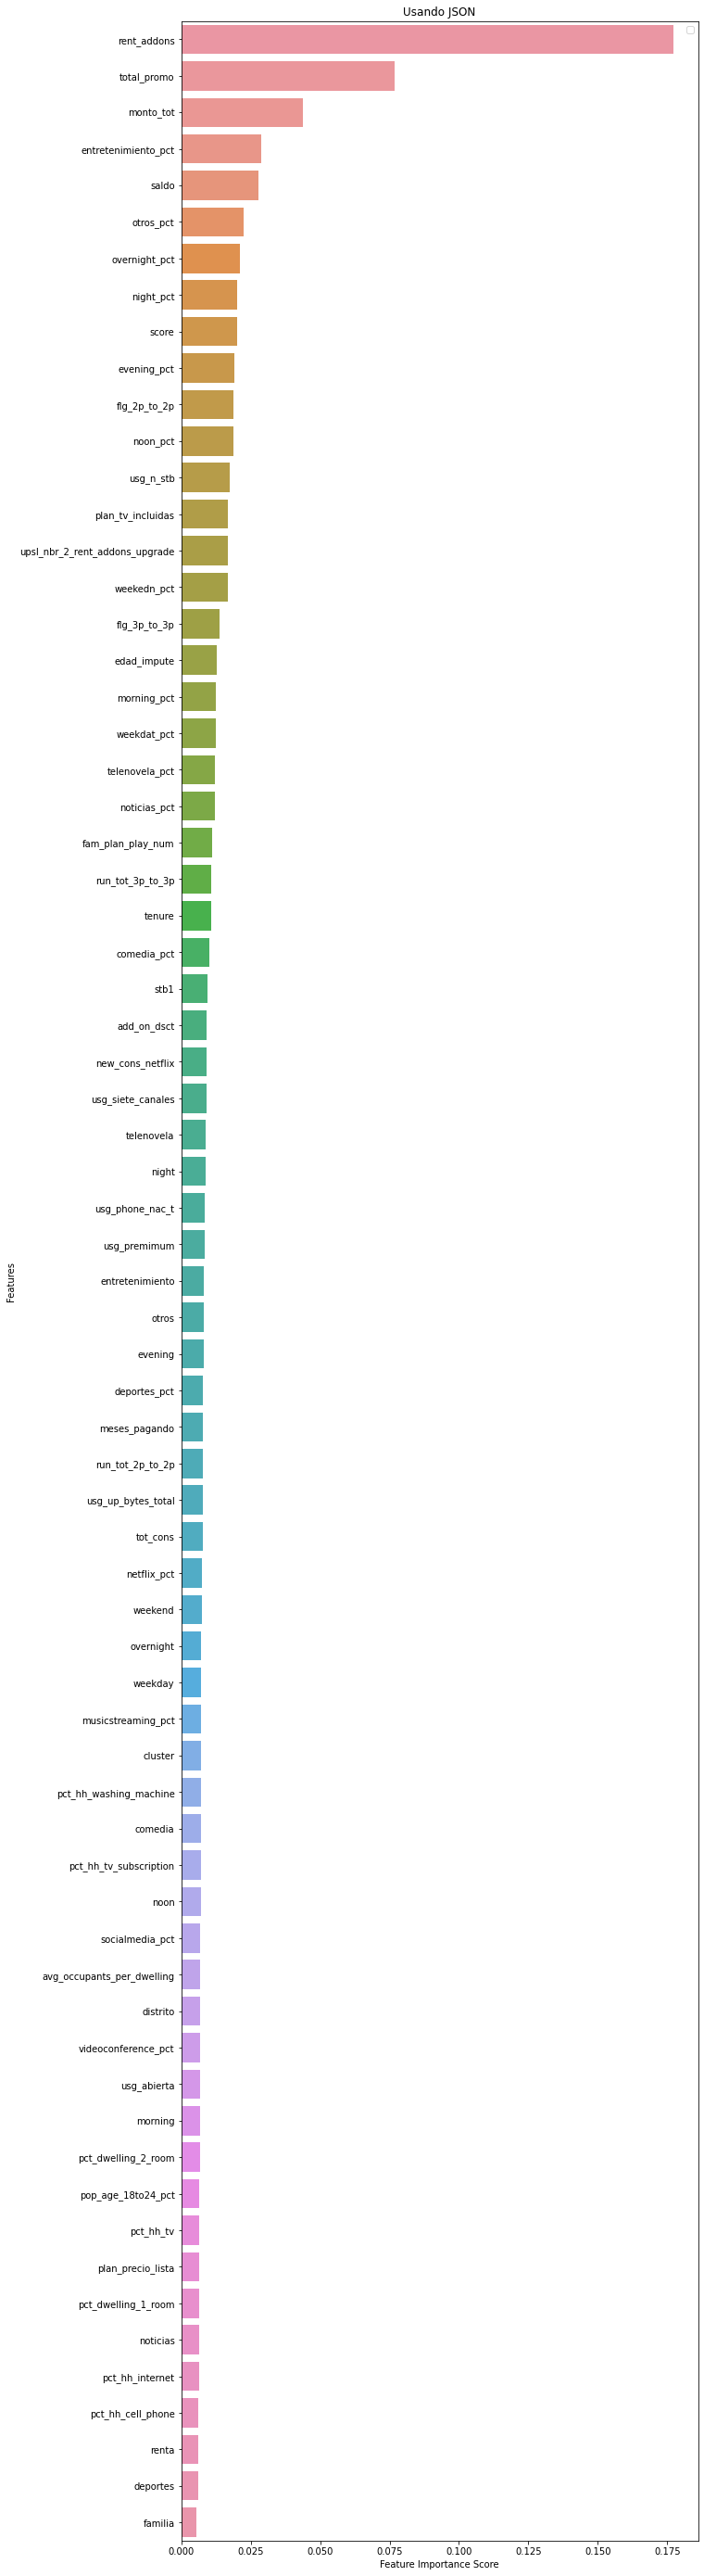

In [62]:
plt.figure(figsize=(10,50))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Usando JSON')
plt.legend()
plt.show()

In [61]:
features=data.columns.to_list()
#features.remove('account')
features.remove('blim')
feature_imp = pd.Series(RFC.feature_importances_,index=features).sort_values(ascending=False)


No handles with labels found to put in legend.


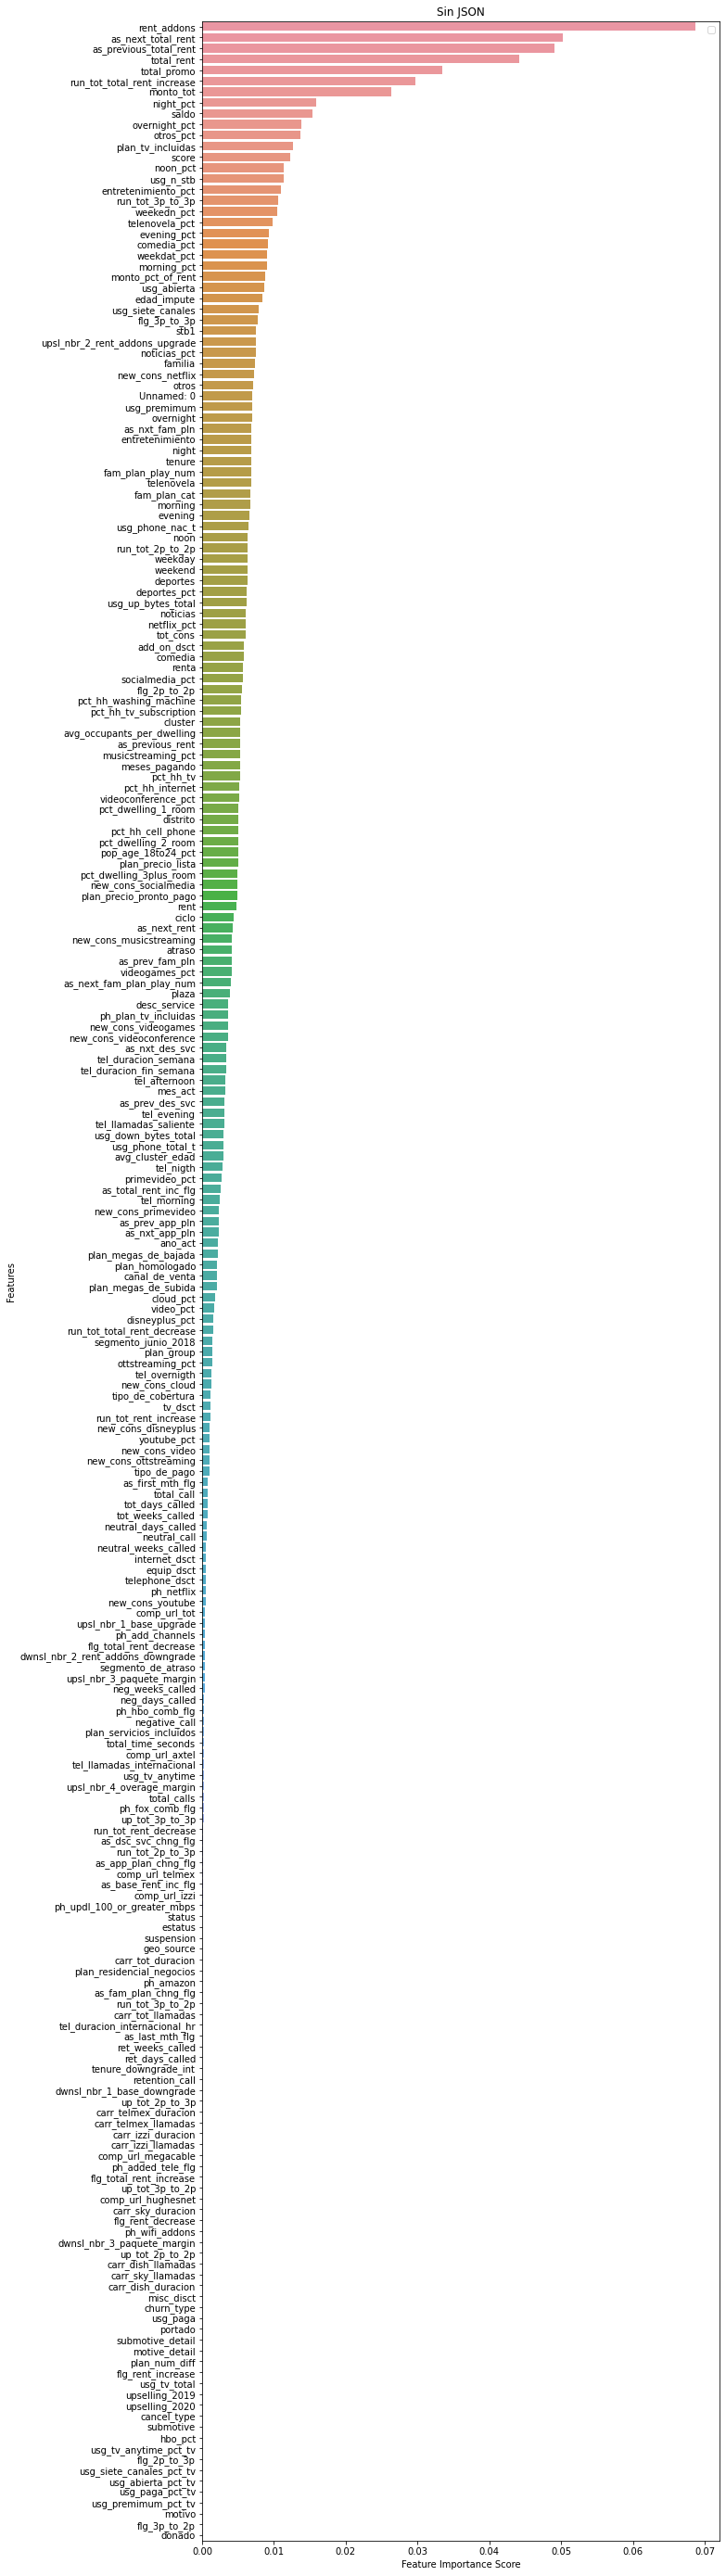

In [17]:
plt.figure(figsize=(10,50))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Sin JSON')
plt.legend()
plt.show()

In [7]:
def get_key(dictionary):
    keys=[]
    for key in dictionary:
        keys.append(key)
    return keys

keys=get_key(json_blim)

In [26]:
for feat in features:
    if feature_imp.loc[feat]>=0.005:
        json[feat]['use']=1
    else:
        json[feat]['use']=0

In [4]:


        
columnas=[]
for i in json_blim.keys():
    if json_blim[i]['use']==1:
        columnas.append(i)
    else:
        pass

In [9]:
zero=['total_rent','as_previous_total_rent','as_next_total_rent','as_previous_rent','run_tot_total_rent_increase',
      'monto_pct_of_rent','as_nxt_fam_pln','fam_plan_cat']

for col in zero:
    json_blim[col]['use']=0

In [3]:
import json 

with open('blim.json','r') as fp:
    json_blim=json.loads(fp.read())
    

In [38]:
import json

with open('blim.json', 'w') as fp:
    json.dump(json_blim, fp)

In [6]:
json_blim

{'account': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'account',
  'variable_sign': 1},
 'edad': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'edad',
  'variable_sign': 1},
 'gpo_edad': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'gpo_edad',
  'variable_sign': 1},
 'plan_homologado': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'plan_homologado',
  'variable_sign': 1},
 'renta': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'renta',
  'variable_sign': 1},
 'familia': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'familia',
  'variable_sign': 1},
 'tipo_de_pago': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'tipo_de_pago',
  'variable_sign': 1},
 'cluster': {'type': 'category',
  'use': 1,
  'imputation': 'unknown',
  'super_category': 'cluster',
  'variable_sign': 1},
 'pl

# Get Predictions

In [30]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_ = sc.fit_transform(X)


In [25]:
predictions=RFC.predict(X)


In [31]:
predicted_proba=RFC.predict_proba(X_)
predict=pd.DataFrame(predicted_proba, columns=['Proba_0','Proba_1'])

In [32]:

predict['account']=acc
predict

,Proba_0,Proba_1,account
0,0.915766,0.084234,1.3248369
1,0.716898,0.283102,1.3298979
2,0.962473,0.037527,1.3306319
3,0.985973,0.014027,1.3325356
4,0.965372,0.034628,1.3307403
...,...,...,...
2737827,0.894554,0.105446,0106529834
2737828,0.815848,0.184152,0106530354
2737829,0.907624,0.092376,0106530479
2737830,0.759812,0.240188,0106530667


In [34]:
predict['Blim']=np.where(predict['Proba_1']>=0.5, 1, 0)
predict

,Proba_0,Proba_1,account,Blim
0,0.915766,0.084234,1.3248369,0
1,0.716898,0.283102,1.3298979,0
2,0.962473,0.037527,1.3306319,0
3,0.985973,0.014027,1.3325356,0
4,0.965372,0.034628,1.3307403,0
...,...,...,...,...
2737827,0.894554,0.105446,0106529834,0
2737828,0.815848,0.184152,0106530354,0
2737829,0.907624,0.092376,0106530479,0
2737830,0.759812,0.240188,0106530667,0


In [35]:
predict=predict[['account','Proba_0','Proba_1','Blim']]
predict

,account,Proba_0,Proba_1,Blim
0,1.3248369,0.915766,0.084234,0
1,1.3298979,0.716898,0.283102,0
2,1.3306319,0.962473,0.037527,0
3,1.3325356,0.985973,0.014027,0
4,1.3307403,0.965372,0.034628,0
...,...,...,...,...
2737827,0106529834,0.894554,0.105446,0
2737828,0106530354,0.815848,0.184152,0
2737829,0106530479,0.907624,0.092376,0
2737830,0106530667,0.759812,0.240188,0


In [37]:
predict['has_blim']=data['blim']
predict

/tmp/ipykernel_1220/1919646604.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict['has_blim']=data['blim']


,account,Proba_0,Proba_1,Blim,has_blim
0,1.3248369,0.915766,0.084234,0,0
1,1.3298979,0.716898,0.283102,0,0
2,1.3306319,0.962473,0.037527,0,0
3,1.3325356,0.985973,0.014027,0,0
4,1.3307403,0.965372,0.034628,0,0
...,...,...,...,...,...
2737827,0106529834,0.894554,0.105446,0,0
2737828,0106530354,0.815848,0.184152,0,0
2737829,0106530479,0.907624,0.092376,0,0
2737830,0106530667,0.759812,0.240188,0,0


In [38]:
predict.drop(predict[predict['has_blim']==1].index, inplace = True)
predict

/home/ubuntu/BI/bi-env/lib/python3.8/site-packages/pandas/core/frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,account,Proba_0,Proba_1,Blim,has_blim
0,1.3248369,0.915766,0.084234,0,0
1,1.3298979,0.716898,0.283102,0,0
2,1.3306319,0.962473,0.037527,0,0
3,1.3325356,0.985973,0.014027,0,0
4,1.3307403,0.965372,0.034628,0,0
...,...,...,...,...,...
2737827,0106529834,0.894554,0.105446,0,0
2737828,0106530354,0.815848,0.184152,0,0
2737829,0106530479,0.907624,0.092376,0,0
2737830,0106530667,0.759812,0.240188,0,0


In [41]:
predict.drop(columns='has_blim',inplace=True)

/home/ubuntu/BI/bi-env/lib/python3.8/site-packages/pandas/core/frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [44]:
predict['Blim'].value_counts()

0    2634665
1      80355
Name: Blim, dtype: int64

In [43]:
predict.to_csv('blim_predictions_agosto.csv')

In [37]:
json_blim={'account': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'account',
  'variable_sign': 1},
 'edad': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'edad',
  'variable_sign': 1},
 'gpo_edad': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'gpo_edad',
  'variable_sign': 1},
 'plan_homologado': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'plan_homologado',
  'variable_sign': 1},
 'renta': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'renta',
  'variable_sign': 1},
 'familia': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'familia',
  'variable_sign': 1},
 'tipo_de_pago': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'tipo_de_pago',
  'variable_sign': 1},
 'cluster': {'type': 'category',
  'use': 1,
  'imputation': 'unknown',
  'super_category': 'cluster',
  'variable_sign': 1},
 'plaza': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'plaza',
  'variable_sign': 1},
 'distrito': {'type': 'category',
  'use': 1,
  'imputation': 'unknown',
  'super_category': 'distrito',
  'variable_sign': 1},
 'nse': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'nse',
  'variable_sign': 1},
 'canal_de_venta': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'canal_de_venta',
  'variable_sign': 1},
 'mes_act': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'mes_act',
  'variable_sign': 1},
 'ano_act': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'ano_act',
  'variable_sign': 1},
 'fecha_activacion': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'fecha_activacion',
  'variable_sign': 1},
 'fecha_activacion_raw': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'fecha_activacion_raw',
  'variable_sign': 1},
 'meses_pagando': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'meses_pagando',
  'variable_sign': 1},
 'segmento_junio_2018': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'segmento_junio_2018',
  'variable_sign': 1},
 'motivo': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'motivo',
  'variable_sign': 1},
 'geo_source': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'geo_source',
  'variable_sign': 1},
 'latitud': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'latitud',
  'variable_sign': 1},
 'longitud': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'longitud',
  'variable_sign': 1},
 'atraso': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'atraso',
  'variable_sign': 1},
 'segmento_de_atraso': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'segmento_de_atraso',
  'variable_sign': 1},
 'estatus': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'estatus',
  'variable_sign': 1},
 'tipo_de_cobertura': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'tipo_de_cobertura',
  'variable_sign': 1},
 'ano_semana': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'ano_semana',
  'variable_sign': 1},
 'donado': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'donado',
  'variable_sign': 1},
 'portado': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'portado',
  'variable_sign': 1},
 'ciclo': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'ciclo',
  'variable_sign': 1},
 'saldo': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'saldo',
  'variable_sign': 1},
 'suspension': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'suspension',
  'variable_sign': 1},
 'tipo_persona': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'tipo_persona',
  'variable_sign': 1},
 'television': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'television',
  'variable_sign': 1},
 'anytime': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'anytime',
  'variable_sign': 1},
 'netflix': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'netflix',
  'variable_sign': 1},
 'youtube': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'youtube',
  'variable_sign': 1},
 'amazon': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'amazon',
  'variable_sign': 1},
 'deezer': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'deezer',
  'variable_sign': 1},
 'vod': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'vod',
  'variable_sign': 1},
 'score': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'score',
  'variable_sign': 1},
 'upselling_2019': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'upselling_2019',
  'variable_sign': 1},
 'upselling_2020': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'upselling_2020',
  'variable_sign': 1},
 'cancel_type': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'cancel_type',
  'variable_sign': 1},
 'motive': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'motive',
  'variable_sign': 1},
 'submotive': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'submotive',
  'variable_sign': 1},
 'motive_detail': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'motive_detail',
  'variable_sign': 1},
 'submotive_detail': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'submotive_detail',
  'variable_sign': 1},
 'churn_type': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'churn_type',
  'variable_sign': 1},
 'cancel_year': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'cancel_year',
  'variable_sign': 1},
 'cancel_month': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'cancel_month',
  'variable_sign': 1},
 'cancelation_week': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'cancelation_week',
  'variable_sign': 1},
 'cancelation_date': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'cancelation_date',
  'variable_sign': 1},
 'status': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'status',
  'variable_sign': 1},
 'desc_service': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'desc_service',
  'variable_sign': 1},
 'rent_addons': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'rent_addons',
  'variable_sign': 1},
 'rent': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'rent',
  'variable_sign': 1},
 'approved_plan': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'approved_plan',
  'variable_sign': 1},
 'family_plan': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'family_plan',
  'variable_sign': 1},
 'total_rent': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'total_rent',
  'variable_sign': 1},
 'period': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'period',
  'variable_sign': 1},
 'billing_month': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'billing_month',
  'variable_sign': 1},
 'as_previous_total_rent': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'as_previous_total_rent',
  'variable_sign': 1},
 'as_next_total_rent': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'as_next_total_rent',
  'variable_sign': 1},
 'as_previous_rent': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'as_previous_rent',
  'variable_sign': 1},
 'as_next_rent': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'as_next_rent',
  'variable_sign': 1},
 'as_prev_app_pln': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'as_prev_app_pln',
  'variable_sign': 1},
 'as_nxt_app_pln': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'as_nxt_app_pln',
  'variable_sign': 1},
 'as_prev_fam_pln': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'as_prev_fam_pln',
  'variable_sign': 1},
 'as_nxt_fam_pln': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'as_nxt_fam_pln',
  'variable_sign': 1},
 'as_prev_des_svc': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'as_prev_des_svc',
  'variable_sign': 1},
 'as_nxt_des_svc': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'as_nxt_des_svc',
  'variable_sign': 1},
 'as_prev_mth': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'as_prev_mth',
  'variable_sign': 1},
 'as_nxt_mth': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'as_nxt_mth',
  'variable_sign': 1},
 'as_base_rent_inc_flg': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'as_base_rent_inc_flg',
  'variable_sign': 1},
 'as_total_rent_inc_flg': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'as_total_rent_inc_flg',
  'variable_sign': 1},
 'as_app_plan_chng_flg': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'as_app_plan_chng_flg',
  'variable_sign': 1},
 'as_fam_plan_chng_flg': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'as_fam_plan_chng_flg',
  'variable_sign': 1},
 'as_dsc_svc_chng_flg': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'as_dsc_svc_chng_flg',
  'variable_sign': 1},
 'as_first_mth_flg': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'as_first_mth_flg',
  'variable_sign': 1},
 'as_last_mth_flg': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'as_last_mth_flg',
  'variable_sign': 1},
 'plan_megas_de_subida': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'plan_megas_de_subida',
  'variable_sign': 1},
 'plan_megas_de_bajada': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'plan_megas_de_bajada',
  'variable_sign': 1},
 'plan_internet_incluidas': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'plan_internet_incluidas',
  'variable_sign': 1},
 'plan_tv_incluidas': {'type': 'category',
  'use': 1,
  'imputation': 'unknown',
  'super_category': 'plan_tv_incluidas',
  'variable_sign': 1},
 'plan_minutos_nacional': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'plan_minutos_nacional',
  'variable_sign': 1},
 'plan_minutos_internacional': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'plan_minutos_internacional',
  'variable_sign': 1},
 'plan_residencial_negocios': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'plan_residencial_negocios',
  'variable_sign': 1},
 'plan_servicios_incluidos': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'plan_servicios_incluidos',
  'variable_sign': 1},
 'plan_precio_pronto_pago': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'plan_precio_pronto_pago',
  'variable_sign': 1},
 'plan_precio_lista': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'plan_precio_lista',
  'variable_sign': 1},
 'fam_plan_cat': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'fam_plan_cat',
  'variable_sign': 1},
 'fam_plan_play_num': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'fam_plan_play_num',
  'variable_sign': 1},
 'as_next_fam_plan_cat': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'as_next_fam_plan_cat',
  'variable_sign': 1},
 'as_next_fam_plan_play_num': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'as_next_fam_plan_play_num',
  'variable_sign': 1},
 'plan_num_diff': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'plan_num_diff',
  'variable_sign': 1},
 'flg_2p_to_3p': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'flg_2p_to_3p',
  'variable_sign': 1},
 'flg_3p_to_2p': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'flg_3p_to_2p',
  'variable_sign': 1},
 'flg_3p_to_3p': {'type': 'category',
  'use': 1,
  'imputation': 'unknown',
  'super_category': 'flg_3p_to_3p',
  'variable_sign': 1},
 'flg_2p_to_2p': {'type': 'category',
  'use': 1,
  'imputation': 'unknown',
  'super_category': 'flg_2p_to_2p',
  'variable_sign': 1},
 'flg_rent_increase': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'flg_rent_increase',
  'variable_sign': 1},
 'flg_total_rent_increase': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'flg_total_rent_increase',
  'variable_sign': 1},
 'flg_rent_decrease': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'flg_rent_decrease',
  'variable_sign': 1},
 'flg_total_rent_decrease': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'flg_total_rent_decrease',
  'variable_sign': 1},
 'run_tot_2p_to_3p': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'run_tot_2p_to_3p',
  'variable_sign': 1},
 'run_tot_3p_to_2p': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'run_tot_3p_to_2p',
  'variable_sign': 1},
 'run_tot_3p_to_3p': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'run_tot_3p_to_3p',
  'variable_sign': 1},
 'run_tot_2p_to_2p': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'run_tot_2p_to_2p',
  'variable_sign': 1},
 'run_tot_rent_increase': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'run_tot_rent_increase',
  'variable_sign': 1},
 'run_tot_total_rent_increase': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'run_tot_total_rent_increase',
  'variable_sign': 1},
 'run_tot_rent_decrease': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'run_tot_rent_decrease',
  'variable_sign': 1},
 'run_tot_total_rent_decrease': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'run_tot_total_rent_decrease',
  'variable_sign': 1},
 'plan_group': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'plan_group',
  'variable_sign': 1},
 'avg_cluster_edad': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'avg_cluster_edad',
  'variable_sign': 1},
 'edad_impute': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'edad_impute',
  'variable_sign': 1},
 'tenure': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'tenure',
  'variable_sign': 1},
 'up_upsell_date': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'up_upsell_date',
  'variable_sign': 1},
 'up_distribuidor': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'up_distribuidor',
  'variable_sign': 1},
 'up_plan_actual': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'up_plan_actual',
  'variable_sign': 1},
 'up_plan_nuevo': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'up_plan_nuevo',
  'variable_sign': 1},
 'up_tipo_movimiento': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'up_tipo_movimiento',
  'variable_sign': 1},
 'up_margen_paquete': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'up_margen_paquete',
  'variable_sign': 1},
 'up_margen_crecimiento': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'up_margen_crecimiento',
  'variable_sign': 1},
 'up_nivel_1': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'up_nivel_1',
  'variable_sign': 1},
 'up_nivel_2': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'up_nivel_2',
  'variable_sign': 1},
 'up_nivel_3': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'up_nivel_3',
  'variable_sign': 1},
 'cl_tech_support_sum': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'cl_tech_support_sum',
  'variable_sign': 1},
 'cl_upsell_sum': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'cl_upsell_sum',
  'variable_sign': 1},
 'cl_downgrade_sum': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'cl_downgrade_sum',
  'variable_sign': 1},
 'cl_non_polar_call_sum': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'cl_non_polar_call_sum',
  'variable_sign': 1},
 'cl_cancelation_sum': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'cl_cancelation_sum',
  'variable_sign': 1},
 'cl_account_issue_complaint_sum': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'cl_account_issue_complaint_sum',
  'variable_sign': 1},
 'cl_retention_sum': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'cl_retention_sum',
  'variable_sign': 1},
 'cl_plan_change_uncertain_level_sum': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'cl_plan_change_uncertain_level_sum',
  'variable_sign': 1},
 'cl_add_on_question_sum': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'cl_add_on_question_sum',
  'variable_sign': 1},
 'usg_n_stb': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'usg_n_stb',
  'variable_sign': 1},
 'usg_phone_nac_t': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'usg_phone_nac_t',
  'variable_sign': 1},
 'usg_phone_int_t': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'usg_phone_int_t',
  'variable_sign': 1},
 'usg_phone_total_t': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'usg_phone_total_t',
  'variable_sign': 1},
 'usg_tv_anytime': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'usg_tv_anytime',
  'variable_sign': 1},
 'usg_down_bytes_total': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'usg_down_bytes_total',
  'variable_sign': 1},
 'usg_up_bytes_total': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'usg_up_bytes_total',
  'variable_sign': 1},
 'usg_siete_canales': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'usg_siete_canales',
  'variable_sign': 1},
 'usg_abierta': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'usg_abierta',
  'variable_sign': 1},
 'usg_paga': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'usg_paga',
  'variable_sign': 1},
 'usg_premimum': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'usg_premimum',
  'variable_sign': 1},
 'videogames_quintile_2020_2h': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'videogames_quintile_2020_2h',
  'variable_sign': 1},
 'video_quintile_2020_2h': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'video_quintile_2020_2h',
  'variable_sign': 1},
 'ottstreaming_quintile_2020_2h': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'ottstreaming_quintile_2020_2h',
  'variable_sign': 1},
 'musicstreaming_quintile_2020_2h': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'musicstreaming_quintile_2020_2h',
  'variable_sign': 1},
 'socialmedia_quintile_2020_2h': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'socialmedia_quintile_2020_2h',
  'variable_sign': 1},
 'cloud_quintile_2020_2h': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'cloud_quintile_2020_2h',
  'variable_sign': 1},
 'videoconference_quintile_2020_2h': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'videoconference_quintile_2020_2h',
  'variable_sign': 1},
 'videogames': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'videogames',
  'variable_sign': 1},
 'video': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'video',
  'variable_sign': 1},
 'ottstreaming': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'ottstreaming',
  'variable_sign': 1},
 'musicstreaming': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'musicstreaming',
  'variable_sign': 1},
 'socialmedia': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'socialmedia',
  'variable_sign': 1},
 'cloud': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'cloud',
  'variable_sign': 1},
 'videoconference': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'videoconference',
  'variable_sign': 1},
 'upsl_nbr_1_base_upgrade': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'upsl_nbr_1_base_upgrade',
  'variable_sign': 1},
 'dwnsl_nbr_1_base_downgrade': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'dwnsl_nbr_1_base_downgrade',
  'variable_sign': 1},
 'upsl_nbr_2_rent_addons_upgrade': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'upsl_nbr_2_rent_addons_upgrade',
  'variable_sign': 1},
 'dwnsl_nbr_2_rent_addons_downgrade': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'dwnsl_nbr_2_rent_addons_downgrade',
  'variable_sign': 1},
 'upsl_nbr_3_paquete_margin': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'upsl_nbr_3_paquete_margin',
  'variable_sign': 1},
 'upsl_nbr_4_overage_margin': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'upsl_nbr_4_overage_margin',
  'variable_sign': 1},
 'dwnsl_nbr_3_paquete_margin': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'dwnsl_nbr_3_paquete_margin',
  'variable_sign': 1},
 'dwnsl_nbr_4_overage_margin': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'dwnsl_nbr_4_overage_margin',
  'variable_sign': 1},
 'up_tot_3p_to_2p': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'up_tot_3p_to_2p',
  'variable_sign': 1},
 'up_tot_2p_to_3p': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'up_tot_2p_to_3p',
  'variable_sign': 1},
 'up_tot_2p_to_2p': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'up_tot_2p_to_2p',
  'variable_sign': 1},
 'up_tot_3p_to_3p': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'up_tot_3p_to_3p',
  'variable_sign': 1},
 'up_sum_margen_paquete': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'up_sum_margen_paquete',
  'variable_sign': 1},
 'up_sum_margen_crecimiento': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'up_sum_margen_crecimiento',
  'variable_sign': 1},
 'up_max_up_megas_change': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'up_max_up_megas_change',
  'variable_sign': 1},
 'up_max_down_megas_change': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'up_max_down_megas_change',
  'variable_sign': 1},
 'up_max_tv_change': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'up_max_tv_change',
  'variable_sign': 1},
 'up_max_minutos_nat_change': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'up_max_minutos_nat_change',
  'variable_sign': 1},
 'up_max_minutos_inter_change': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'up_max_minutos_inter_change',
  'variable_sign': 1},
 'up_max_services_inc_change': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'up_max_services_inc_change',
  'variable_sign': 1},
 'up_max_precio_pronto_change': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'up_max_precio_pronto_change',
  'variable_sign': 1},
 'up_max_precio_lista_change': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'up_max_precio_lista_change',
  'variable_sign': 1},
 'pop_under_18_pct': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'pop_under_18_pct',
  'variable_sign': 1},
 'pop_age_18to24_pct': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'pop_age_18to24_pct',
  'variable_sign': 1},
 'pop_age_25to59_pct': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'pop_age_25to59_pct',
  'variable_sign': 1},
 'pop_age_gt60_pct': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'pop_age_gt60_pct',
  'variable_sign': 1},
 'pct_hh_cell_phone': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'pct_hh_cell_phone',
  'variable_sign': 1},
 'pct_hh_internet': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'pct_hh_internet',
  'variable_sign': 1},
 'pct_hh_washing_machine': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'pct_hh_washing_machine',
  'variable_sign': 1},
 'pct_hh_tv_subscription': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'pct_hh_tv_subscription',
  'variable_sign': 1},
 'pct_hh_tv': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'pct_hh_tv',
  'variable_sign': 1},
 'avg_occupants_per_dwelling': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'avg_occupants_per_dwelling',
  'variable_sign': 1},
 'pct_dwelling_1_room': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'pct_dwelling_1_room',
  'variable_sign': 1},
 'pct_dwelling_2_room': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'pct_dwelling_2_room',
  'variable_sign': 1},
 'pct_dwelling_3plus_room': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'pct_dwelling_3plus_room',
  'variable_sign': 1},
 'total_promo': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'total_promo',
  'variable_sign': 1},
 'add_on_dsct': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'add_on_dsct',
  'variable_sign': 1},
 'internet_dsct': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'internet_dsct',
  'variable_sign': 1},
 'telephone_dsct': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'telephone_dsct',
  'variable_sign': 1},
 'equip_dsct': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'equip_dsct',
  'variable_sign': 1},
 'tv_dsct': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'tv_dsct',
  'variable_sign': 1},
 'misc_disct': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'misc_disct',
  'variable_sign': 1},
 'ret_150_netflix_1tv': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'ret_150_netflix_1tv',
  'variable_sign': 1},
 'ret_150_netflix_2tv': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'ret_150_netflix_2tv',
  'variable_sign': 1},
 'ret_150_netflix_4tv': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'ret_150_netflix_4tv',
  'variable_sign': 1},
 'ret_150_amazon': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'ret_150_amazon',
  'variable_sign': 1},
 'ret_150': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'ret_150',
  'variable_sign': 1},
 'ret_100_netflix_1tv': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'ret_100_netflix_1tv',
  'variable_sign': 1},
 'ret_100_netflix_2tv': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'ret_100_netflix_2tv',
  'variable_sign': 1},
 'ret_100_netflix_4tv': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'ret_100_netflix_4tv',
  'variable_sign': 1},
 'ret_100_amazon': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'ret_100_amazon',
  'variable_sign': 1},
 'ret_100': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'ret_100',
  'variable_sign': 1},
 'ret_prev_price': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'ret_prev_price',
  'variable_sign': 1},
 'ret_10_percent': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'ret_10_percent',
  'variable_sign': 1},
 'ret_50_percent_netflix_1tv': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'ret_50_percent_netflix_1tv',
  'variable_sign': 1},
 'ret_50_percent_netflix_2tv': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'ret_50_percent_netflix_2tv',
  'variable_sign': 1},
 'ret_50_percent_netflix_4tv': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'ret_50_percent_netflix_4tv',
  'variable_sign': 1},
 'ret_50_percent_amazon': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'ret_50_percent_amazon',
  'variable_sign': 1},
 'ret_50_percent': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'ret_50_percent',
  'variable_sign': 1},
 'ret_free_tv': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'ret_free_tv',
  'variable_sign': 1},
 'ret_star_prem_50_percent': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'ret_star_prem_50_percent',
  'variable_sign': 1},
 'ret_star_prem': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'ret_star_prem',
  'variable_sign': 1},
 'ret_initial': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'ret_initial',
  'variable_sign': 1},
 'prt_carrier': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'prt_carrier',
  'variable_sign': 1},
 'prt_clasificacion': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'prt_clasificacion',
  'variable_sign': 1},
 'tech_support_call': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'tech_support_call',
  'variable_sign': 1},
 'account_question_call': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'account_question_call',
  'variable_sign': 1},
 'cancelation_call': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'cancelation_call',
  'variable_sign': 1},
 'payment_call': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'payment_call',
  'variable_sign': 1},
 'plan_chg_call': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'plan_chg_call',
  'variable_sign': 1},
 'upsell_call': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'upsell_call',
  'variable_sign': 1},
 'downgrade_call': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'downgrade_call',
  'variable_sign': 1},
 'ret_call': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'ret_call',
  'variable_sign': 1},
 'acct_issue_call': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'acct_issue_call',
  'variable_sign': 1},
 'other_call': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'other_call',
  'variable_sign': 1},
 'neutral_call': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'neutral_call',
  'variable_sign': 1},
 'negative_call': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'negative_call',
  'variable_sign': 1},
 'retention_call': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'retention_call',
  'variable_sign': 1},
 'total_call': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'total_call',
  'variable_sign': 1},
 'neg_days_called': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'neg_days_called',
  'variable_sign': 1},
 'neutral_days_called': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'neutral_days_called',
  'variable_sign': 1},
 'ret_days_called': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'ret_days_called',
  'variable_sign': 1},
 'tot_days_called': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'tot_days_called',
  'variable_sign': 1},
 'neg_weeks_called': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'neg_weeks_called',
  'variable_sign': 1},
 'neutral_weeks_called': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'neutral_weeks_called',
  'variable_sign': 1},
 'ret_weeks_called': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'ret_weeks_called',
  'variable_sign': 1},
 'tot_weeks_called': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'tot_weeks_called',
  'variable_sign': 1},
 'new_cons_videogames': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'new_cons_videogames',
  'variable_sign': 1},
 'new_cons_video': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'new_cons_video',
  'variable_sign': 1},
 'new_cons_ottstreaming': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'new_cons_ottstreaming',
  'variable_sign': 1},
 'new_cons_musicstreaming': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'new_cons_musicstreaming',
  'variable_sign': 1},
 'new_cons_socialmedia': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'new_cons_socialmedia',
  'variable_sign': 1},
 'new_cons_hbo': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'new_cons_hbo',
  'variable_sign': 1},
 'new_cons_cloud': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'new_cons_cloud',
  'variable_sign': 1},
 'new_cons_videoconference': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'new_cons_videoconference',
  'variable_sign': 1},
 'new_cons_netflix': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'new_cons_netflix',
  'variable_sign': 1},
 'new_cons_primevideo': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'new_cons_primevideo',
  'variable_sign': 1},
 'new_cons_youtube': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'new_cons_youtube',
  'variable_sign': 1},
 'new_cons_disneyplus': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'new_cons_disneyplus',
  'variable_sign': 1},
 'ab_dec': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'ab_dec',
  'variable_sign': 1},
 'pm_dec': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'pm_dec',
  'variable_sign': 1},
 'tv_add_dec': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'tv_add_dec',
  'variable_sign': 1},
 'dwn_byt_dec': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'dwn_byt_dec',
  'variable_sign': 1},
 'netflix_dec': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'netflix_dec',
  'variable_sign': 1},
 'primevideo_dec': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'primevideo_dec',
  'variable_sign': 1},
 'disneyplus_dec': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'disneyplus_dec',
  'variable_sign': 1},
 'hbo_dec': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'hbo_dec',
  'variable_sign': 1},
 'socialmedia_dec': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'socialmedia_dec',
  'variable_sign': 1},
 'videoconference_dec': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'videoconference_dec',
  'variable_sign': 1},
 'cloud_dec': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'cloud_dec',
  'variable_sign': 1},
 'musicstreaming_dec': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'musicstreaming_dec',
  'variable_sign': 1},
 'entertainment_dec': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'entertainment_dec',
  'variable_sign': 1},
 'streaming_dec': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'streaming_dec',
  'variable_sign': 1},
 'usg_segment': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'usg_segment',
  'variable_sign': 1},
 'stb1': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'stb1',
  'variable_sign': 1},
 'stb2': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'stb2',
  'variable_sign': 1},
 'stb3': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'stb3',
  'variable_sign': 1},
 'stb4': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'stb4',
  'variable_sign': 1},
 'weekday': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'weekday',
  'variable_sign': 1},
 'weekend': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'weekend',
  'variable_sign': 1},
 'morning': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'morning',
  'variable_sign': 1},
 'noon': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'noon',
  'variable_sign': 1},
 'evening': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'evening',
  'variable_sign': 1},
 'night': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'night',
  'variable_sign': 1},
 'overnight': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'overnight',
  'variable_sign': 1},
 'noticias': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'noticias',
  'variable_sign': 1},
 'entretenimiento': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'entretenimiento',
  'variable_sign': 1},
 'comedia': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'comedia',
  'variable_sign': 1},
 'telenovela': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'telenovela',
  'variable_sign': 1},
 'deportes': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'deportes',
  'variable_sign': 1},
 'otros': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'otros',
  'variable_sign': 1},
 'comp_url_axtel': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'comp_url_axtel',
  'variable_sign': 1},
 'comp_url_telmex': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'comp_url_telmex',
  'variable_sign': 1},
 'comp_url_izzi': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'comp_url_izzi',
  'variable_sign': 1},
 'comp_url_megacable': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'comp_url_megacable',
  'variable_sign': 1},
 'comp_url_hughesnet': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'comp_url_hughesnet',
  'variable_sign': 1},
 'comp_url_tot': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'comp_url_tot',
  'variable_sign': 1},
 'total_time_seconds': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'total_time_seconds',
  'variable_sign': 1},
 'total_calls': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'total_calls',
  'variable_sign': 1},
 'fecha_pago': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'fecha_pago',
  'variable_sign': 1},
 'descripcion_pago': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'descripcion_pago',
  'variable_sign': 1},
 'fecha_pago_reflejo': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'fecha_pago_reflejo',
  'variable_sign': 1},
 'mes_pago': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'mes_pago',
  'variable_sign': 1},
 'monto_tot': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'monto_tot',
  'variable_sign': 1},
 'tel_duracion_semana': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'tel_duracion_semana',
  'variable_sign': 1},
 'tel_duracion_fin_semana': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'tel_duracion_fin_semana',
  'variable_sign': 1},
 'tel_morning': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'tel_morning',
  'variable_sign': 1},
 'tel_afternoon': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'tel_afternoon',
  'variable_sign': 1},
 'tel_evening': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'tel_evening',
  'variable_sign': 1},
 'tel_nigth': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'tel_nigth',
  'variable_sign': 1},
 'tel_overnigth': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'tel_overnigth',
  'variable_sign': 1},
 'tel_llamadas_saliente': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'tel_llamadas_saliente',
  'variable_sign': 1},
 'tel_llamadas_internacional': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'tel_llamadas_internacional',
  'variable_sign': 1},
 'tel_duracion_internacional_hr': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'tel_duracion_internacional_hr',
  'variable_sign': 1},
 'carr_telmex_duracion': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'carr_telmex_duracion',
  'variable_sign': 1},
 'carr_izzi_duracion': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'carr_izzi_duracion',
  'variable_sign': 1},
 'carr_sky_duracion': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'carr_sky_duracion',
  'variable_sign': 1},
 'carr_dish_duracion': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'carr_dish_duracion',
  'variable_sign': 1},
 'carr_telmex_llamadas': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'carr_telmex_llamadas',
  'variable_sign': 1},
 'carr_izzi_llamadas': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'carr_izzi_llamadas',
  'variable_sign': 1},
 'carr_sky_llamadas': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'carr_sky_llamadas',
  'variable_sign': 1},
 'carr_dish_llamadas': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'carr_dish_llamadas',
  'variable_sign': 1},
 'carr_tot_duracion': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'carr_tot_duracion',
  'variable_sign': 1},
 'carr_tot_llamadas': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'carr_tot_llamadas',
  'variable_sign': 1},
 'addon_promo_category': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'addon_promo_category',
  'variable_sign': 1},
 'mths_after_promo': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'mths_after_promo',
  'variable_sign': 1},
 'tenure_downgrade_int': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'tenure_downgrade_int',
  'variable_sign': 1},
 'prt_flg': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'prt_flg',
  'variable_sign': 1},
 'prt_carrier_grp': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'prt_carrier_grp',
  'variable_sign': 1},
 'tot_cons': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'tot_cons',
  'variable_sign': 1},
 'usg_tv_total': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'usg_tv_total',
  'variable_sign': 1},
 'videogames_pct': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'videogames_pct',
  'variable_sign': 1},
 'video_pct': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'video_pct',
  'variable_sign': 1},
 'ottstreaming_pct': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'ottstreaming_pct',
  'variable_sign': 1},
 'musicstreaming_pct': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'musicstreaming_pct',
  'variable_sign': 1},
 'socialmedia_pct': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'socialmedia_pct',
  'variable_sign': 1},
 'hbo_pct': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'hbo_pct',
  'variable_sign': 1},
 'cloud_pct': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'cloud_pct',
  'variable_sign': 1},
 'videoconference_pct': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'videoconference_pct',
  'variable_sign': 1},
 'netflix_pct': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'netflix_pct',
  'variable_sign': 1},
 'primevideo_pct': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'primevideo_pct',
  'variable_sign': 1},
 'youtube_pct': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'youtube_pct',
  'variable_sign': 1},
 'disneyplus_pct': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'disneyplus_pct',
  'variable_sign': 1},
 'usg_tv_anytime_pct_tv': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'usg_tv_anytime_pct_tv',
  'variable_sign': 1},
 'usg_siete_canales_pct_tv': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'usg_siete_canales_pct_tv',
  'variable_sign': 1},
 'usg_abierta_pct_tv': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'usg_abierta_pct_tv',
  'variable_sign': 1},
 'usg_paga_pct_tv': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'usg_paga_pct_tv',
  'variable_sign': 1},
 'usg_premimum_pct_tv': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'usg_premimum_pct_tv',
  'variable_sign': 1},
 'weekdat_pct': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'weekdat_pct',
  'variable_sign': 1},
 'weekedn_pct': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'weekedn_pct',
  'variable_sign': 1},
 'morning_pct': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'morning_pct',
  'variable_sign': 1},
 'noon_pct': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'noon_pct',
  'variable_sign': 1},
 'evening_pct': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'evening_pct',
  'variable_sign': 1},
 'night_pct': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'night_pct',
  'variable_sign': 1},
 'overnight_pct': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'overnight_pct',
  'variable_sign': 1},
 'noticias_pct': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'noticias_pct',
  'variable_sign': 1},
 'entretenimiento_pct': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'entretenimiento_pct',
  'variable_sign': 1},
 'comedia_pct': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'comedia_pct',
  'variable_sign': 1},
 'telenovela_pct': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'telenovela_pct',
  'variable_sign': 1},
 'deportes_pct': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'deportes_pct',
  'variable_sign': 1},
 'otros_pct': {'type': 'float',
  'use': 1,
  'imputation': 'zero',
  'super_category': 'otros_pct',
  'variable_sign': 1},
 'acct_issue_call_ten_adj': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'acct_issue_call_ten_adj',
  'variable_sign': 1},
 'account_question_call_ten_adj': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'account_question_call_ten_adj',
  'variable_sign': 1},
 'add_on_call_ten_adj': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'add_on_call_ten_adj',
  'variable_sign': 1},
 'cancelation_call_ten_adj': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'cancelation_call_ten_adj',
  'variable_sign': 1},
 'downgrade_call_ten_adj': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'downgrade_call_ten_adj',
  'variable_sign': 1},
 'payment_call_ten_adj': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'payment_call_ten_adj',
  'variable_sign': 1},
 'plan_chg_call_ten_adj': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'plan_chg_call_ten_adj',
  'variable_sign': 1},
 'acc_ret_call_ten_adj': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'acc_ret_call_ten_adj',
  'variable_sign': 1},
 'offer_ret_call_ten_adj': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'offer_ret_call_ten_adj',
  'variable_sign': 1},
 'rejec_ret_call_ten_adj': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'rejec_ret_call_ten_adj',
  'variable_sign': 1},
 'tech_support_call_ten_adj': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'tech_support_call_ten_adj',
  'variable_sign': 1},
 'upsell_call_ten_adj': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'upsell_call_ten_adj',
  'variable_sign': 1},
 'other_call_ten_adj': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'other_call_ten_adj',
  'variable_sign': 1},
 'total_call_ten_adj': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'total_call_ten_adj',
  'variable_sign': 1},
 'ph_added_tele_flg': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'ph_added_tele_flg',
  'variable_sign': 1},
 'ph_plan_tv_incluidas': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'ph_plan_tv_incluidas',
  'variable_sign': 1},
 'ph_netflix': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'ph_netflix',
  'variable_sign': 1},
 'ph_amazon': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'ph_amazon',
  'variable_sign': 1},
 'ph_fox_comb_flg': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'ph_fox_comb_flg',
  'variable_sign': 1},
 'ph_hbo_comb_flg': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'ph_hbo_comb_flg',
  'variable_sign': 1},
 'ph_updl_100_or_greater_mbps': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'ph_updl_100_or_greater_mbps',
  'variable_sign': 1},
 'ph_wifi_addons': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'ph_wifi_addons',
  'variable_sign': 1},
 'ph_add_channels': {'type': 'category',
  'use': 0,
  'imputation': 'unknown',
  'super_category': 'ph_add_channels',
  'variable_sign': 1},
 'monto_pct_of_rent': {'type': 'float',
  'use': 0,
  'imputation': 'zero',
  'super_category': 'monto_pct_of_rent',
  'variable_sign': 1}}
